Solid immersion lens - modified from Huiyao's Matlab code

In [1]:
# mill a SIL with less milled material with the same NA
# previous version (full hemisphere with 45 degree side wall) effective NA ~ 0.894 = Sin[ArcTan[2]]

# The milling rate remains the same for a fixed:
# viewwidth/magnification and ion current(30 kV 9.86 nA) and millingstep;

# If the magnification changes, then each pixel effective area changes, the
# milling rate changes by cube of the magnification change, i.e., changes
# from 10X to 20X, each pixel is 1/4 of the original size, to ensure the
# same milling rate of each pixel, the dwell time has to be reduced to 1/8.
# However, SIL automation are just a series of points, the dwelling time
# shouln't vary too much for different magnification, once the milling step
# is set.

# One would sill better re-calibrate the etch rate when magnification changes.

# FIB stream file generation

In [2]:
# use the following for matplotlib upgrade
# python -m pip install --upgrade --user matplotlib
# some issues with permission

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
import skimage

In [2]:
FOVX = [ 0, 4095] # field of view
FOVY = [280, 3816]
NA = 0.8
thetaNA = np.arcsin(NA)
print(thetaNA)
outputfile = True
seee = False
FileNameSIL = 'New600us21nA' # change it according to the set ion beam current

0.927295218002


In [3]:
viewwidth=42.58 #um width of the ion view.2000X 
R_sil= 5# um
R_cone=R_sil*2 # um 
layerdepth=0.1 # um  0.1 um, DO NOT change 

dwelltime=600 #us  This is going to be dependent on the etch/milling rate  
# 1200 for diamond
# and 900 for SiC at 9.3 nA beam current selection
# 9.86 nA, dwell time: 1200 us; diamond
# 21 nA, dwell time: 600us; diamond
millingstep=0.1 # um  0.1 um, DO NOT change

# back calculate
# assume the ion beam diameter is significantly larger than step size
# in this regime, the FIB surface is smooth instead of a number of holes
# 4096 pixel equivalent to 42.58 um (at 2000x mag), 0.0104 um/pixel
# millingstep (in XY) 0.1 um
# 600 us, 21 nA, mill away 0.1*0.1*0.1 um^3

In [4]:
# volume/charge

0.1**3/600e-6

1.6666666666666672

In [ ]:
# at 21 nA, mill away 1.67 um**3 per second


In [67]:
def compute_milled_volume(NA,R):
    thetaNA = np.arcsin(NA)
    cone_vol = (1./3)*np.pi*R * (R* np.tan(thetaNA)  )**2
    part_sphere_vol  = 4./3*np.pi*R**3 * (1-np.cos(thetaNA))/2
    return cone_vol-part_sphere_vol

def compute_45deg_SIL_vol(NA,R):
    thetaNA = np.arcsin(NA)
    part_cone_vol = 1./3* np.pi * 8*R**3  *7/8
    hemi_vol = 2./3*np.pi*R**3
    return part_cone_vol-hemi_vol

In [68]:
compute_milled_volume(0.8,10),compute_45deg_SIL_vol(0.8,5)

(1023.9264945033402, 654.4984694978737)

In [69]:
1023/1.67/60

10.209580838323353

In [70]:
compute_milled_volume(0.8,10),compute_45deg_SIL_vol(0.8,5)

(1023.9264945033402, 654.4984694978737)

In [11]:
np.pi

3.141592653589793

In [5]:
# generate SIL center in Ion beam view:
# (X,Y) coordinate system
C0=[-10,-15] # fiducial left 1 in ion beam view
C1=[9,-14] # fiducial right 2 in ion beam view
R0s=17.2675 # um, fiducial 1 distance to SIL center
R1s=19.2369 # um, fiducial 2 distance to SIL center
SILrelpos=-1 # -1 left of line 0->1, +1 right of line 0->1

R01=np.sqrt((C1[0]-C0[0])**2+(C1[1]-C0[1])**2)
correction=R01/20 # norminal separation 20 um
angle01=np.arctan((C1[0]-C0[0])/(C1[1]-C0[1])) # angle tilt of fiducials in FIB view
angle0s=np.arccos((20**2+R0s**2-R1s**2)/(2*20*R0s))

if C1[0]-C0[0] < 0:
    print('Please swap fiducials!')
    
if angle01<0:
    angle01=angle01+pi

if SILrelpos>0:  #being right of the line
    SILcenterx=C0[0]+R0s*np.sin(angle01+angle0s)*correction;
    SILcentery=C0[1]+R0s*np.cos(angle01+angle0s)*correction;
else:
    SILcenterx=C0[0]+R0s*np.sin(angle01-angle0s)*correction;
    SILcentery=C0[1]+R0s*np.cos(angle01-angle0s)*correction;

SILcenter=[SILcenterx,SILcentery]


In [14]:
def plot_fiducial_and_sil(C0,C1,SILcenter):
    threePts = np.asarray([C0 ,C1 ,SILcenter ,C0]).transpose()
    fig, axs = plt.subplots(1, 1)
    plt.plot(threePts[0,:],threePts[1,:],'o-')
    plt.scatter(SILcenterx,SILcentery,c='red')
    axs.axis('equal')
    # axs.set_title('Ion view', fontsize=10)
    # plt.legend()
    plt.title("Ion view")
    
def compute_layers(R0,layerdepth,thetaNA):
    """
    compute inner and outer radius at each depth
    
    return inner, outer radius,yy [um]
    """
    # yy=R-layerdepth:-layerdepth:0 # for 45 deg version
    yy = np.arange(R0-layerdepth,R0*np.cos(thetaNA),-layerdepth) # vertical distance above sphere center
    
    # in micron
    xxSILinner=np.round(np.sqrt(R0**2-yy**2),2) #tracing out the circular profile, one can modify this to adapt to other curves, like a parabola.
    # xxSILouter=round(yy+R,2);% 45 degree tilt
    xxSILouter=yy*np.tan(thetaNA) # thetaNA tilt
    return xxSILinner,xxSILouter,yy    

def compute_45deg_layers(R0,layerdepth,thetaNA):
    """
    compute inner and outer radius at each depth
    
    return inner, outer radius,yy [um]
    """
    # yy - vertical distance above sphere center 
    yy = np.arange(R0-layerdepth,0,-layerdepth)#45 deg version
#     yy = np.arange(R0-layerdepth,R0*np.cos(thetaNA),-layerdepth)
    
    # in micron
    xxSILinner=np.round(np.sqrt(R0**2-yy**2),2) #tracing out the circular profile, one can modify this to adapt to other curves, like a parabola.
    xxSILouter=np.round(yy+R0,2) # 45 degree tilt
#     xxSILouter=yy*np.tan(thetaNA) # thetaNA tilt
    return xxSILinner,xxSILouter,yy    

def plot_layers(xxSILinner,xxSILouter,yy,R0):
    """
    plot sil layers cross-section
    """
    fig, axs = plt.subplots(1, 1)
    plt.plot(xxSILinner,yy,'o-')
    plt.plot(xxSILouter,yy,'o-')
    plt.scatter(0,0,c='red')

    plt.plot(xxSILouter,yy,'o-')

    plt.plot(xxSILouter,yy,'o-')

    plt.plot(np.arange(0,R0*1.3,0.1),  1/np.tan(np.arcsin(NA))*np.arange(0,R0*1.3,0.1))

    plt.plot(np.arange(0,R0/2,0.1),  1/np.tan(np.arcsin(NA/2.4))*np.arange(0,R0/2,0.1))


    for i,v in enumerate(yy):
        plt.plot([xxSILinner[i], xxSILouter[i]],[v, v]);

    # axis equal;
    plt.xlim([0,1.1*max(xxSILouter)])
    plt.ylim([0,R0+max(xxSILouter)/2])
    plt.xlabel('x(um)');
    plt.ylabel('z(um)');
    plt.title('milling factor 1.4')#  what is milling factor?

    # output list inner diamter, outerdiameter, depth
    # list size = number of layers = R_sil/layerdepth
    siltab= np.zeros( (len(yy),3)  )
    siltab[:,1]=xxSILinner*2;
    siltab[:,0]=xxSILouter*2;
    # siltab[:,3]=[layerdepth,-np.diff(yy)*1.4];

    axs.axis('equal')
    plt.text(R0*2/2,R0/3,'layer#= ' + str(len(siltab)) )

def gen_tXYZ_file(xxSILinner,xxSILouter,yy,R):
    """
    tXYZ file in
    dwell time [0.1 us], inner radius [um], outer radius [um], height [um]
    """
    siltab= np.zeros( (len(yy),3)  )
    siltab[:,1]=xxSILinner*2;
    siltab[:,0]=xxSILouter*2;
    tXYZ=np.empty((0,4))
    Ntot = len(siltab)
    for n,val in enumerate(siltab):
        outerdia=siltab[n,0]
        innerdia=siltab[n,1]

        # one layer
        for millR in np.arange(innerdia/2,outerdia/2,millingstep ):
            # one ring
            philist= np.arange(   n/Ntot*2*np.pi,(2*np.pi+n/Ntot*2*np.pi  ),millingstep/millR   )
            ringlen = len(philist)
            milltXYZ = np.zeros((ringlen,4)  )
            for phiind, phi in enumerate(philist):            
                milltXYZ[phiind,:] = np.array( [dwelltime*10,millR*np.cos(phi),millR*np.sin(phi),yy[n]])
            tXYZ = np.concatenate((tXYZ, milltXYZ), axis=0)
    return tXYZ

def tXYZ_to_stream(tXYZ,viewwidth,SILcenter=[0,0]):
    """
    stream format in pixel    
    """
    #map coordinate to Ion grid
    mapscalefactor=4096/viewwidth # pixel/um
    stream = np.zeros((len(tXYZ),3 ))
    
    [SILcenterx,SILcentery] = SILcenter

    # shift X,Y center 
    stream[:,1] = ((tXYZ[:,1]+SILcenterx)*mapscalefactor)+4096/2
    stream[:,2] = ((tXYZ[:,2]+SILcentery)*mapscalefactor)+4096/2

    stream[:,0]=dwelltime*10 # in 0.1 us

    stream = stream.astype(int)
    return stream

def gen_and_write_stream(R0,layerdepth,thetaNA,SILcenter=[0,0],plotLayers = True, plot2D =True, plot3D = True, writeToFile = True,filename = "newSIL.str"):
    """
    """
    
#     inR, outR, yheight = compute_layers(R0,layerdepth,thetaNA)
    inR, outR, yheight = compute_45deg_layers(R0,layerdepth,thetaNA)
    if plotLayers:
        plot_layers(inR, outR, yheight,R0)
        
    
    thistXYZ = gen_tXYZ_file(inR,outR,yheight,R0)
    thisstream = tXYZ_to_stream(thistXYZ ,viewwidth,SILcenter)
    if plot2D:
        scatter_plot_2d(thisstream)
    if plot3D:
        scatter_plot_3d_surface(inR,outR,yheight)
    
    if writeToFile:
        write_stream_to_file(filename,thisstream)
    
    return thisstream

def scatter_plot_2d(stream):
    """
    scatter plot stream file
    """
    fig,axs = plt.subplots(1, 1)
    XX = stream[:,1]
    YY = stream[:,2]   
    
    plt.scatter(XX/4095.*40-20,(YY-280)/4095.*40-20)
#     plt.scatter(XX,YY)
    
    axs.axis('equal')
    plt.xlabel('x(um)')
    plt.ylabel('y(um)')
    plt.autoscale(enable=True, axis='y')
    plt.autoscale(enable=True, axis='x')
    
def scatter_plot_3d_tXYZ(tXYZ):
    """
    scatter plot stream file
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
    for t,xx,yy,zz in tXYZ:
        ax.scatter(xx, yy, zz, marker=m)

    ax.set_xlabel('X [um]')
    ax.set_ylabel('Y [um]')
    ax.set_zlabel('Z [um]')

    plt.show()

def scatter_plot_3d_surface(xxSILinner,xxSILouter,yy):
    """
    scatter plot stream file
    """
    
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    philist = np.arange(0,2*np.pi,0.1   ) 
    # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
    for ind,y0 in enumerate(yy):    
        
         
        xx = np.cos(philist)*xxSILinner[ind]
        yy = np.sin(philist)*xxSILinner[ind]
        ax.scatter(xx, yy, y0)
        
        xx = np.cos(philist)*xxSILouter[ind]
        yy = np.sin(philist)*xxSILouter[ind]
        ax.scatter(xx, yy, y0)

    ax.set_xlabel('X [um]')
    ax.set_ylabel('Y [um]')
    ax.set_zlabel('Z [um]')

    routmax = max(xxSILouter)
    
    ax.set_xlim(-1.1*routmax,1.1*routmax)
    ax.set_ylim(-1.1*routmax,1.1*routmax)
    ax.set_zlim(0, 2.2*routmax)
#     ax.axis('equal')
    plt.show()
    
def write_stream_to_file(filename,streamarray):
    """
    output .str file

    stream file format
    dwell_time X Y  
    """
    with open(filename, 'w') as the_file:
        the_file.write(  '%s\n' % 's')
        the_file.write(  '%s\n' % '1')
        the_file.write(  '%s\n' % str(len(streamarray)))
        for line in streamarray:
            linestr = " ".join(str(elem) for elem in line)+'\n'
            the_file.write(linestr)
    print("Total time = " +str(len(streamarray)*dwelltime/10**6*1.0     ) + " sec")
    
def read_and_plot(filename):
    FOVX=[0 ,4095]
    FOVY=[280, 3816]
    Areadtest=np.loadtxt(filename,skiprows=3)
    XX = Areadtest[:,1]
    YY = Areadtest[:,2]
    fig,axs = plt.subplots(1, 1)
    plt.scatter(XX/4095.*40-20,(YY-280)/4095.*40-20)
    axs.axis('equal')



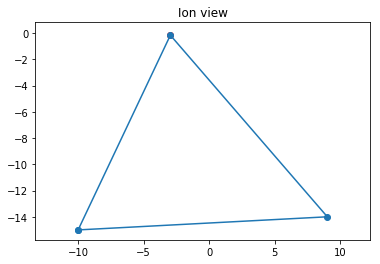

In [7]:
plot_fiducial_and_sil(C0,C1,SILcenter)

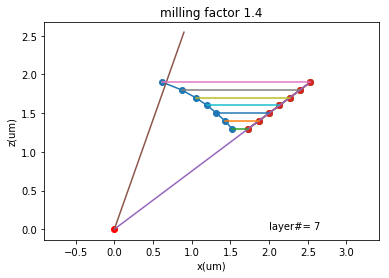

In [8]:
inR,outR,yheight = compute_layers(2,layerdepth,thetaNA)
plot_layers(inR,outR,yheight,2)

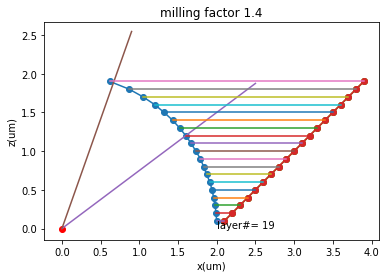

In [16]:
inR,outR,yheight = compute_45deg_layers(2,layerdepth,thetaNA)
plot_layers(inR,outR,yheight,2)

In [48]:
thistXYZ = gen_tXYZ_file(inR,outR,yheight ,10)
len(thistXYZ)

7551

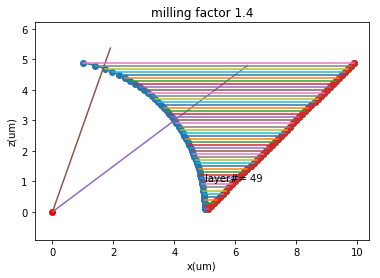

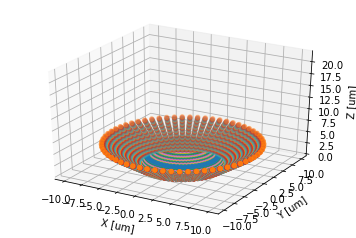

Total time = 387.0 sec


In [17]:
tstream=gen_and_write_stream(R_sil,layerdepth,thetaNA,plot2D=False)

In [57]:
len(tstream)

1004587

In [68]:
387./60


6.45

In [ ]:
# show trjactory of milling

if seee:
    fig,axs = plt.subplots(1, 1)
    scatter3(str(:,2),str(:,3),str(:,4),[],linspace(1,10,size(str,1)),'filled');
    hold on; plot3(str(:,2),str(:,3),str(:,4));
    axis equal;
    shading interp;


#map coordinate to Ion grid

# mapscalefactor=4096/viewwidth # pixel/um

# str(:,2:3)=str(:,2:3);
# %str(:,2)=int16((str(:,2)+SILcenterx).*mapscalefactor)+4096/2; %if need to
# %shift the center
# %str(:,3)=int16((str(:,3)+SILcentery).*mapscalefactor)+4096/2;

# % no center shift; SIL at field of view center
# str(:,2)=int16((str(:,2)).*mapscalefactor)+4096/2;
# str(:,3)=int16((str(:,3)).*mapscalefactor)+4096/2;

# see=1;   %if you want to see
# if see
# figure;
# plot(str(:,2),str(:,3));
# hold on;
# plot(plot1(1,:).*mapscalefactor+4096/2,plot1(2,:).*mapscalefactor+4096/2,'o-'); hold on;
# scatter(SILcenterx.*mapscalefactor+4096/2,SILcentery.*mapscalefactor+4096/2,'filled');
# axis equal;
# xlim([0,4096]);
# ylim([0,4096]);
# end


Total time = 0.0 sec


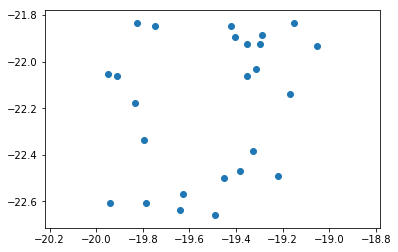

In [68]:
# generate test .str file 25 points array.

# data = [96,1229,2867;96,1639,2867;96,2048,2867;96,2457,2867;96,2867,2867;96,1229,2457;96,1639,2457;96,2048,2457;96,2457,2457;96,2867,2457;96,1229,2048;96,1639,2048;96,2048,2048;96,2457,2048;96,2867,2048;96,1229,1639;96,1639,1639;96,2048,1639;96,2457,1639;96,2867,1639;96,1229,1229;96,1639,1229;96,2048,1229;96,2457,1229;96,2867,1229]
data= np.random.rand(25,3)*100

time = 98.*(np.zeros((1,25))+1) # 0.1 us
Atest = np.zeros((25,3))
Atest[:,0] = time
Atest[:,1] = data[:,1]
Atest[:,2] = data[:,2]

Atest=Atest.astype(int)

write_stream_to_file('testwrite.str',Atest)
read_and_plot('testwrite.str')

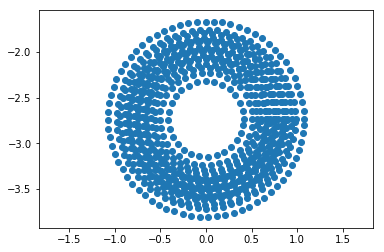

In [132]:
read_and_plot('newSIL.str')

In [ ]:

"""{
Parameters:

    width        = width of the writing area [micron]

    mu           = milling rate [micron**3 / (micro s * nA )]
    I            = beam current [nA]  9 nA 
    ds           = step size in the x-y-plane [micron]

    R_sil        = radius of the SIL [micron]
    R_cone       = outer radius of the cone around the SIL [micron]
    N            = number of slices. The geometry is divided into N slices.
    rep          = number of repetitions. Note that the milling time on each pixel is
                   divided by the number of repetitons, i.e., the number of
                   repetitions just determines 'how smooth' the milling is done
                   and not how long.    

    position     = position of the structure on the writing area [micron]

Output:
    sil.str      = stream file 
}
""" 

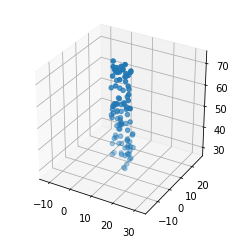

In [17]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect('equal')

X = np.random.rand(100)*10+5
Y = np.random.rand(100)*5+2.5
Z = np.random.rand(100)*50+25

scat = ax.scatter(X, Y, Z)

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()

In [ ]:
# generate pattern and text


In [18]:
from PIL import Image, ImageFont
img = Image.new('L', (500, 500), color=0)
img_w, img_h = img.size
font = ImageFont.truetype('arial.ttf', 20)
mask = font.getmask('Leonardo-B', mode='L')
mask_w, mask_h = mask.size
print(mask_w,mask_h)
print(type(mask))
d = Image.core.draw(img.im, 0)
# d = d.rotate(40)
d.draw_bitmap(((img_w - mask_w)/2, (img_h - mask_h)/2), mask, 255)
img = img.rotate(40)
img.show()
img.save('op.jpg')

(104, 15)
<type 'ImagingCore'>


In [24]:
# white text on black background
from PIL import Image, ImageDraw, ImageFont
import numpy as np

img = Image.new('RGB', (512, 512), color = (0,0, 0))
 
# fnt = ImageFont.truetype('/Library/Fonts/Arial.ttf', 15)
d = ImageDraw.Draw(img)
font = ImageFont.truetype('arial.ttf', 30)
d.text((10,10), "Upper Left", fill=(255, 255, 255),font=font)
# text = 'Upper left'
# mask = [x for x in fnt.getmask(text, mode='1')]
# # img.putdata(mask)
# img.putdata(mask)
    
xscan = np.arange(100,461,40)
yscan = np.arange(100,461,40)

rX = 2
rY = 2

for x in xscan:
    for y in yscan:
        bbox =  (x - rX, y - rY, x + rX, y + rY)
        d.ellipse(bbox, fill = (255, 255, 255), outline =(255, 255, 255))

        
fontsmall = ImageFont.truetype('arial.ttf', 15)
for ind,x in enumerate(xscan):
    d.text((x-5,70), str(ind+1), fill=(255, 255, 255),font=fontsmall)

for ind,y in enumerate(yscan):
    d.text((70,y-10), str(ind+1), fill=(255, 255, 255),font=fontsmall)

    
# img = img.convert('1') # convert image to black and white
    
    
img.save('pil_text_font.bmp')

img.show()
# display(Image(filename='pil_text_font.png'))

In [100]:

img = Image.new('RGB', (1024, 1024), color = (0,0, 0))
 
# fnt = ImageFont.truetype('/Library/Fonts/Arial.ttf', 15)
d = ImageDraw.Draw(img)
font = ImageFont.truetype('arial.ttf', 60)
# d.text((200,20), "Left", fill=(255, 255, 255),font=font)


fontlarge = ImageFont.truetype('arial.ttf', 300)
# d.text((0,-80), "+", fill=(255, 255, 255),font=fontlarge)


# text = 'Upper left'
# mask = [x for x in fnt.getmask(text, mode='1')]
# # img.putdata(mask)
# img.putdata(mask)
    
xscan = np.arange(200,921,80)
yscan = np.arange(200,921,80)

rX = 6
rY = 6

for x in xscan:
    for y in yscan:
        bbox =  (x - rX, y - rY, x + rX, y + rY)
        d.ellipse(bbox, fill = (255, 255, 255), outline =(255, 255, 255))

        
fontsmall = ImageFont.truetype('arial.ttf', 40)
for ind,x in enumerate(xscan):
#     d.text((x-10,120), str(ind+1), fill=(255, 255, 255),font=fontsmall)

for ind,y in enumerate(yscan):
#     d.text((120,y-20), str(ind+1), fill=(255, 255, 255),font=fontsmall)

    
img = img.convert('1') # convert image to black and white
    
    
# img.save('Leftdots.bmp')

# img.show()
# display(Image(filename='pil_text_font.png'))

IndentationError: expected an indented block (<ipython-input-100-d21879a646a3>, line 35)

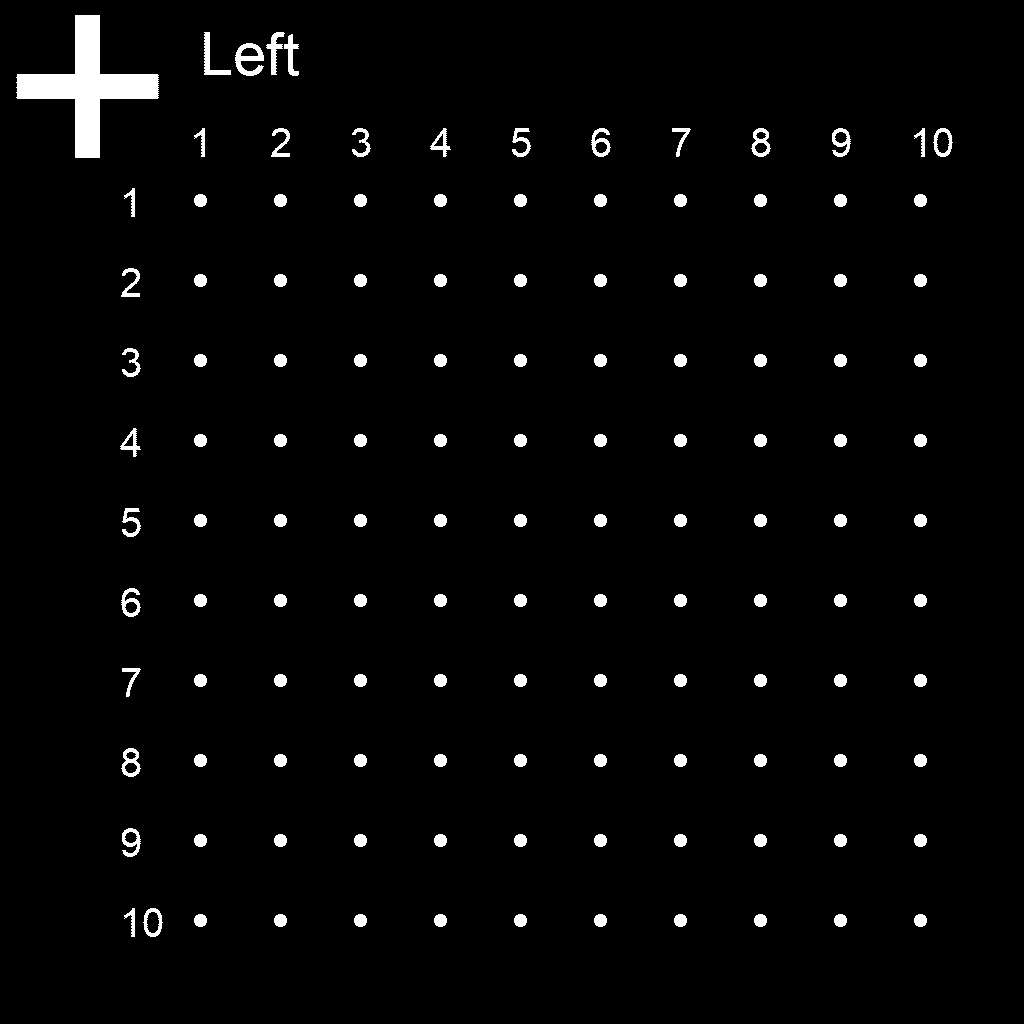

In [102]:
img

In [91]:
data = np.asarray( img, dtype="int32" )

In [92]:
thisarray  =np.asarray(data)

In [93]:
new_array = np.zeros((1024,1024))

In [97]:
new_array  = thisarray[:,:]

In [98]:
np.count_nonzero(new_array)

26468

In [89]:
29269*(1./8)*(1./8)

457.328125

In [96]:
len(thisarray)

1024

In [67]:

img = Image.new('RGB', (1024, 1024), color = (0,0, 0))
 
# fnt = ImageFont.truetype('/Library/Fonts/Arial.ttf', 15)
d = ImageDraw.Draw(img)
font = ImageFont.truetype('arial.ttf', 60)
d.text((680,20), "Right", fill=(255, 255, 255),font=font)
fontlarge = ImageFont.truetype('arial.ttf', 300)
d.text((800,-70), "+", fill=(255, 255, 255),font=fontlarge)


# text = 'Upper left'
# mask = [x for x in fnt.getmask(text, mode='1')]
# # img.putdata(mask)
# img.putdata(mask)
    
xscan = np.arange(200,921,80)
yscan = np.arange(200,921,80)

rX = 6
rY = 6

for x in xscan:
    for y in yscan:
        bbox =  (x - rX, y - rY, x + rX, y + rY)
        d.ellipse(bbox, fill = (255, 255, 255), outline =(255, 255, 255))

        
fontsmall = ImageFont.truetype('arial.ttf', 40)
for ind,x in enumerate(xscan):
    d.text((x-10,120), str(ind+1), fill=(255, 255, 255),font=fontsmall)

for ind,y in enumerate(yscan):
    d.text((120,y-20), str(ind+1), fill=(255, 255, 255),font=fontsmall)

    
# img = img.convert('1') # convert image to black and white
    
    
img.save('Rightdots.bmp')

img.show()
# display(Image(filename='pil_text_font.png'))

In [62]:
img = Image.new('RGB', (400, 400), color = (0,0, 0))
# fnt = ImageFont.truetype('/Library/Fonts/Arial.ttf', 15)
d = ImageDraw.Draw(img)
font = ImageFont.truetype('arial.ttf', 60)
d.text((20,20), "Leonardo-B", fill=(255, 255, 255),font=font)
fontlarge= ImageFont.truetype('arial.ttf', 300)
d.text((100,0), "+", fill=(255, 255, 255),font=fontlarge)
# text = 'Upper left'
# mask = [x for x in fnt.getmask(text, mode='1')]
# # img.putdata(mask)
# img.putdata(mask)
    
    
# img = img.convert('1') # convert image to black and white
    
    
img.save('crossLeonardoB.bmp')

img.show()
# display(Image(filename='pil_text_font.png'))

In [31]:
img = Image.new('RGB', (500, 400), color = (0,0, 0))
# fnt = ImageFont.truetype('/Library/Fonts/Arial.ttf', 15)
d = ImageDraw.Draw(img)
font = ImageFont.truetype('arial.ttf', 60)
d.text((20,20), "Silicon 20191009", fill=(255, 255, 255),font=font)
fontlarge= ImageFont.truetype('arial.ttf', 120)
d.text((160,60), "+", fill=(255, 255, 255),font=fontlarge)
# text = 'Upper left'
# mask = [x for x in fnt.getmask(text, mode='1')]
# # img.putdata(mask)
# img.putdata(mask)
    
    
# img = img.convert('1') # convert image to black and white
    
    
img.save('silicon_cross.bmp')

img.show()
# display(Image(filename='pil_text_font.png'))

In [64]:
img = Image.new('RGB', (400, 400), color = (0,0, 0))
# fnt = ImageFont.truetype('/Library/Fonts/Arial.ttf', 15)
d = ImageDraw.Draw(img)
font = ImageFont.truetype('arial.ttf', 60)
d.text((20,20), "2810753-3 A", fill=(255, 255, 255),font=font)
fontlarge= ImageFont.truetype('arial.ttf', 300)
d.text((100,0), "+", fill=(255, 255, 255),font=fontlarge)
# text = 'Upper left'
# mask = [x for x in fnt.getmask(text, mode='1')]
# # img.putdata(mask)
# img.putdata(mask)
    
    
# img = img.convert('1') # convert image to black and white
    
    
img.save('cross2810753A.bmp')

img.show()
# display(Image(filename='pil_text_font.png'))

In [65]:
img = Image.new('RGB', (400, 400), color = (0,0, 0))
# fnt = ImageFont.truetype('/Library/Fonts/Arial.ttf', 15)
d = ImageDraw.Draw(img)
# font = ImageFont.truetype('arial.ttf', 60)
# d.text((20,20), "2810753-3 A", fill=(255, 255, 255),font=font)
fontlarge= ImageFont.truetype('arial.ttf', 300)
d.text((100,0), "+", fill=(255, 255, 255),font=fontlarge)
# text = 'Upper left'
# mask = [x for x in fnt.getmask(text, mode='1')]
# # img.putdata(mask)
# img.putdata(mask)
    
    
# img = img.convert('1') # convert image to black and white
    
    
img.save('cross_only.bmp')

img.show()
# display(Image(filename='pil_text_font.png'))

In [25]:
from PIL import Image, ImageFont

fnt = ImageFont.truetype('arial.ttf', 50)
text = 'test, test'
img = Image.new('1', fnt.getsize(text))
mask = [x for x in fnt.getmask(text, mode='1')]
img.putdata(mask)
img.show()